In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
from matplotlib import pyplot as plt

mi.set_variant("llvm_ad_spectral_polarized")
print(mi.variants())

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']


In [24]:
def spherical_to_cartesian(radius, phi, theta):
	return mi.ScalarTransform4f().rotate([0, 1, 0], phi).rotate([1, 0, 0], theta) @ mi.ScalarPoint3f([0, 0, radius])

In [34]:
def load_scene(polarizer_theta, phis, thetas, radius):
	face_diffuse_texture = mi.load_dict({
		"type": "bitmap",
		"filename": "../textures/diffuse_albedo.exr"
	})

	face_specular_texture = mi.load_dict({
		"type": "bitmap",
		"filename": "../textures/specular_intensity.exr"
	})

	scene_dict = {
		"type": "scene",
		"integrator": {
			"type": "volpath",
			"max_depth": -1
		},
		"sensor": {
			"type": "perspective",
			"to_world": mi.ScalarTransform4f().look_at(origin=[0, 0, 5], target=[0, 0, 0], up=[0, 1, 0]),
			"sampler": {
				"type": "independent",
				"sample_count": 32
			},
			"film": {
				"type": "hdrfilm",
				"width": 512,
				"height": 512
			}
		},
		"face": {
			"type": "obj",
			"filename": "../meshes/low-res.obj",
			"to_world": mi.ScalarTransform4f().translate([0, -1, 0]).scale(0.0857405).translate([0, 5.0986, 0]),
			"bsdf": {
				"type": "pplastic",
				"diffuse_reflectance": face_diffuse_texture,
				"specular_reflectance": face_specular_texture,
				"alpha": 0.8
			}
		},
		"light": {
			"type": "obj",
			"filename": "../meshes/plane.obj",
			"to_world": mi.ScalarTransform4f().translate([0, 0, 6]).rotate(axis=[0, 1, 0], angle=180),
			"emitter": {
				"type": "area",
				"radiance": {
					"type": "rgb",
					"value": 100
				}
			},
			"bsdf": {
				"type": "diffuse"
			}
		},
		"polarizer_light": {
			"type": "obj",
			"filename": "../meshes/plane.obj",
			"to_world": mi.ScalarTransform4f().look_at(origin=[0, 0, 5], target=[0, 0, 0], up=[0, 1, 0]),
			"bsdf": {
				"type": "polarizer",
				"theta": {
					"type": "spectrum",
					"value": 0
				}
			}
		}
	}

	for i, phi, theta in zip(range(len(phis)), phis, thetas):
		scene_dict[f"polarizer{i}"] = {
			"type": "obj",
			"filename": "../meshes/plane.obj",
			"to_world": mi.ScalarTransform4f().look_at(origin=spherical_to_cartesian(radius-1, phi, theta), target=[0, 0, 0], up=[0, 1, 0]),
			"bsdf": {
				"type": "polarizer",
				"theta": {
					"type": "spectrum",
					"value": polarizer_theta
				}
			}
		}

	return mi.load_dict(scene_dict)

def load_sensor(phi, theta, width, height, sample_count):
	return mi.load_dict({
		"type": "perspective",
		"to_world": mi.ScalarTransform4f().look_at(origin=spherical_to_cartesian(5, phi, theta), target=[0, 0, 0], up=[0, 1, 0]),
		"sampler": {
			"type": "independent",
			"sample_count": sample_count
		},
		"film": {
			"type": "hdrfilm",
			"width": width,
			"height": height
		}
	})

In [35]:
width = 512
height = 512
sample_count = 32

phis = [-35, 35, 0, 0]
thetas = [0, 0, -35, 35]

radius = 5

sensors = [load_sensor(phi, theta, width, height, sample_count) for phi, theta in zip(phis, thetas)]

scene_parallel = load_scene(0, phis, thetas, radius)
scene_orthogonal = load_scene(90, phis, thetas, radius)

In [37]:
def calculate_direct_indirect_illumination(scene_p, scene_o, sensors):
	direct = []
	indirect = []

	for sensor in sensors:
		parallel = mi.render(scene_p, sensor=sensor)
		orthogonal = mi.render(scene_o, sensor=sensor)

		unpol = 2 * np.fmin(parallel, orthogonal)
		pol = parallel - unpol / 2

		direct.append(pol)
		indirect.append(unpol)

	return direct, indirect

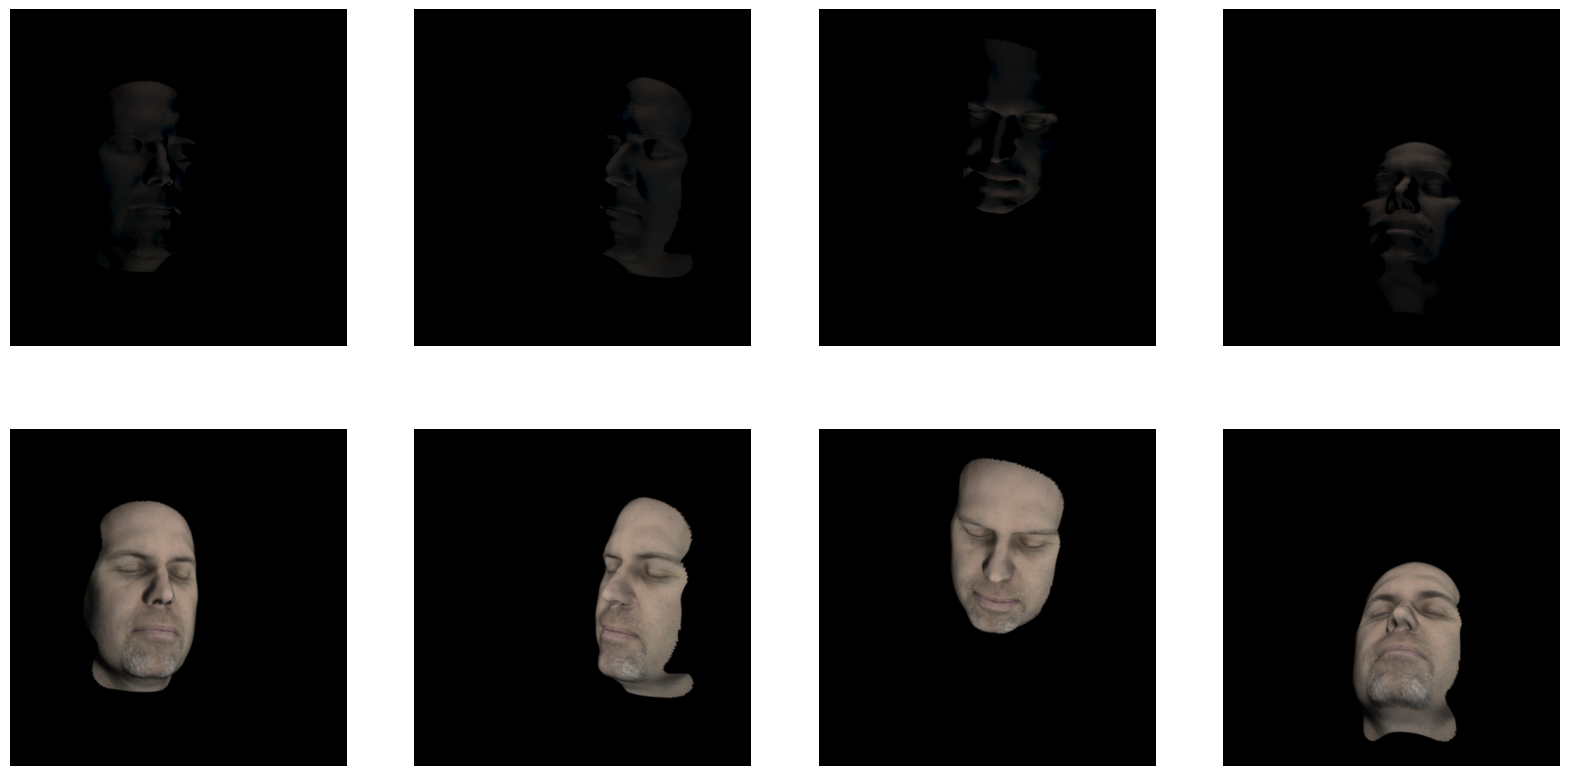

In [41]:
direct, indirect = calculate_direct_indirect_illumination(scene_parallel, scene_orthogonal, sensors)

fig, ax = plt.subplots(2, 4, squeeze=True, figsize=(20, 10))

for i, pol, unpol in zip(range(len(direct)), direct, indirect):
	ax[0, i].axis("off")
	ax[0, i].imshow(pol ** (1.0 / 2.2))
	ax[1, i].axis("off")
	ax[1, i].imshow(unpol ** (1.0 / 2.2))

plt.show()